### Details:
* Author: Gayathri Nadar (Cellular Imaging Facility, FMP Berlin)
* Date: 2022-10
* For: Group 1 project work
* Sections of notebook adapted from https://github.com/haesleinhuepf/apoc/blob/main/demo/demo_object_segmenter.ipynb and https://github.com/haesleinhuepf/apoc/blob/main/demo/train_on_folders.ipynb 

### What does it do?
* Read images in folder, randomly pick one for training an Object classifier in napari-devbio package.
* Initially training could be done by adding labels in napari window. 
* Option to also load labels from image file - possibly saved using napari > labels > save as image. 
* We train a classifier to identify cytoplasm region in cells. 

### Prediction postprocessing 
The output labels are postprocessed to remove unwanted regions - **Courtesy: Daniel Waiger Daniel.Waiger@mail.huji.ac.il**

### Output
* Model, labels if drawn manually, label map output from classifier prediction.


In [1]:
import napari 
import skimage 
from skimage import data
from skimage.io import imread, imshow, imsave
import pyclesperanto_prototype as cle
import numpy as np
import apoc
import os 
from os.path import isfile, join
import random

datadir = "./data/TIFF/cl80/"
savedir = os.path.join(os.path.dirname(os.path.dirname(datadir)), "Results")
if not os.path.exists(savedir):
	os.makedirs(savedir)
    
def postprocessLabelImage(rawimage, label_segmentationoutput, sizemin=5000, sizemax=50000):
    dilated = cle.dilate_labels(label_segmentationoutput, None, 2.0)
    sizefiltered = cle.exclude_labels_outside_size_range(dilated, None, sizemin, sizemax)
    merged = cle.merge_labels_with_border_intensity_within_range(image, sizefiltered, None, 2.0, 100.0)
    final = cle.relabel_sequential(merged, None, 4.0)
   
    return final 

def addNapariLabelLayer(viewer, labelimage, name=""):
    viewer.add_labels(labelimage, name=name)
    
def applyObjectSegmentator(clfile, image):
    clf = apoc.ObjectSegmenter(opencl_filename=clfile)
    outputlabels = clf.predict(image=image)
    
    return outputlabels

### Get files to process

In [2]:
files = [f for f in os.listdir(datadir) if isfile(os.path.join(datadir, f)) and f.startswith("C4") and f.endswith(".tif")]
files

['C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap1.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap2.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap3.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap4.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap5.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap6.tif',
 'C4_cl80_s1_lame1_line1_slice2_th_psyn_lamp1_lc3_x40_snap7.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap1.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap2.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap3.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap4.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap5.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap6.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap7.tif',
 'C4_cl80_s1_lame1_line1_slice3_th_psyn_lamp1_lc3_x40_snap8.tif',
 'C4_cl80_

### Pick a random image to train on

C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


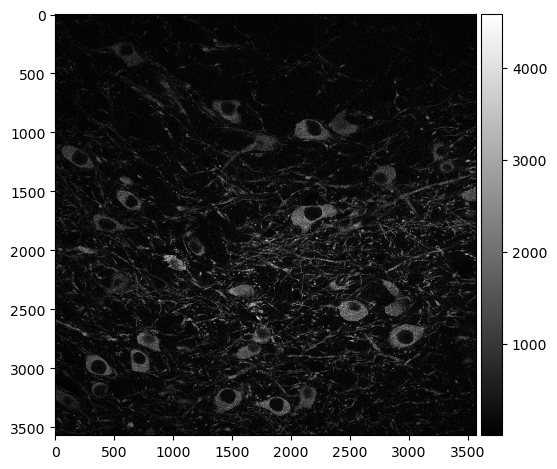

In [3]:
n = random.randint(0, len(files) - 1)
train_image = files[n]

image = imread(join(datadir, train_image))
imshow(image, cmap= 'gray')

### Open Napari to add images (and labels)

In [15]:
# start napari
viewer = napari.Viewer()
napari.run()

# add image
viewer.add_image(image)

<Image layer 'image' at 0x22186198670>

##### Set next parameter to True if you want to add labels manually

In [16]:
add_labels_manually = True

##### If you let the above parameter as False, enter the path to labels corresponding to training image selected, in the cell below. 
Else, skip

In [17]:
labelsfile = join(savedir, "labels_" + train_image)

#### If add_labels_manually == True, please add labels by painting 2 classes in window that pops up after running next cell

**Class 1 = Background**

**Class 2 = Cell cytoplasm**

Else, it will be read from the path specified for labels

In [18]:
if add_labels_manually == True:
    # add an empty labels layer and keep it in a variable
    labels = np.zeros(image.shape).astype(int)
    addNapariLabelLayer(viewer, labels, name="labels")
    
    # save labels
    labels = viewer.layers['labels'].data
    imsave(join(savedir, "labels_" + train_image), labels)
    
else:
    # read labels
    labels = imread(labelsfile)
    addNapariLabelLayer(viewer, labels, name="labels")

C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


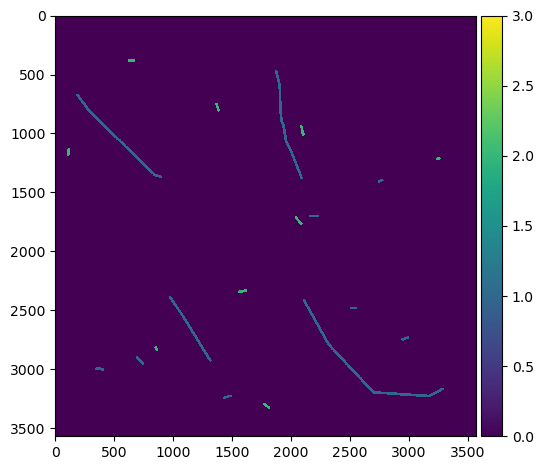

In [19]:
imshow(labels, vmin=0, vmax=3)

### Train using image and labels

In [20]:
# define features
# features = apoc.PredefinedFeatureSet.medium_quick.value
features = "gaussian_blur=1 difference_of_gaussian=1 laplace_box_of_gaussian_blur=1 sobel_of_gaussian_blur=1  sobel_of_gaussian_blur=3  laplace_box_of_gaussian_blur=3  difference_of_gaussian=3  gaussian_blur=3  gaussian_blur=2  difference_of_gaussian=2  laplace_box_of_gaussian_blur=2  sobel_of_gaussian_blur=2 original"

# this is where the model will be saved
cl_filename = join(savedir, 'Model1.cl')
apoc.erase_classifier(cl_filename)

# train 
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, max_depth=5, num_ensembles = 200, positive_class_identifier=2)
clf.train(features, labels, image)

### Do prediction on trained image

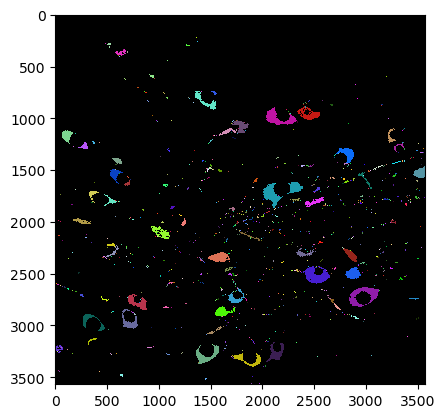

In [21]:
segmentation_result = clf.predict(features=features, image=image)
cle.imshow(segmentation_result, labels=True)

addNapariLabelLayer(viewer, segmentation_result, name="prediction")

### Postprocess output - dilate labels, filter by size, merge based on greyscale values, remap labels

C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\pyclesperanto_prototype\_tier3\_generate_touch_mean_intensity_matrix.py:30: UserWarning: generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.
Loss of information is possible when passing non-integer images.
  warnings.warn("generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.\n" +
C:\ProgramData\Anaconda3\envs\ilastik-napari-devbio\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
C:\Users\nadar.gayathri\AppData\Local\Temp\ipykernel_18668\3650374792.py:7: UserWarning: ./data/TIFF\Results\output_C4_cl80_s1_lame1_line1_slice4_th_psyn_lamp1_lc3_x40_snap3.tif is a low contrast image
  imsave(join(savedir, "output_" + train_image), final_output)


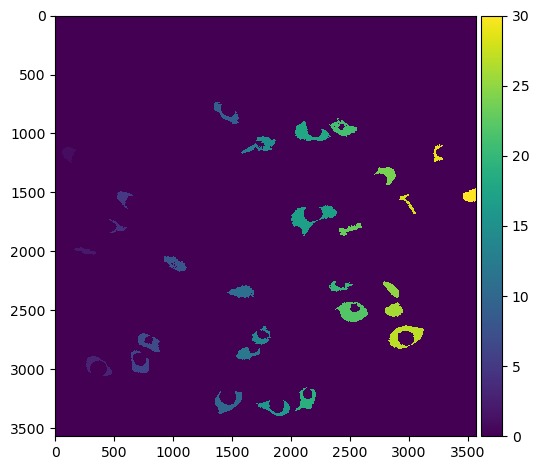

In [13]:
final_output = postprocessLabelImage(image, segmentation_result, sizemin=5000, sizemax=50000)
addNapariLabelLayer(viewer, final_output, name="final")

imshow(final_output)

# save output
imsave(join(savedir, "output_" + train_image), final_output)

### Test apply model on other data

In [ ]:
# model
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename)

# image
image_test = imread(join(datadir, files[5]))

# predict 
output_test = clf.predict(image=image_test)
output_test_final = postprocessLabelImage(image_test, output_test)

# show, save
cle.imshow(output_test_final, labels=True)
imsave(join(savedir, "output_" + files[5]), output_test_final)


### Applying prediction on all files in a loop 

***Currently failing due to out of memory error - GPU not being used :(***

Could be done in a separate notebook!

In [ ]:
modelfile = join(savedir, "Model.cl")

clf = apoc.ObjectSegmenter(opencl_filename=modelfile)

for ff in files:
    im = imread(join(datadir, ff))
    pred = clf.predict(image=im)
    pred_final = postprocessLabelImage(im, pred)
    imsave(join(savedir, "output_" + ff), pred_final)
    
    del im 
    del pred
    del pred_final